In [1]:
import os

import pandas as pd
import numpy as np
import time as tm
import datetime as dt
import tensorflow as tf

# Data preparation
from yahoo_fin import stock_info as yf
from sklearn.preprocessing import MinMaxScaler
from collections import deque
import sqlalchemy as sa

# AI
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

# Graphics library
import matplotlib.pyplot as plt

Warning - Certain functionality 
             requires requests_html, which is not installed.
             
             Install using: 
             pip install requests_html
             
             After installation, you may have to restart your Python session.


In [2]:
# SETTINGS

# Window size or the sequence length, 7 (1 week)
N_STEPS = 7

# Lookup steps, 1 is the next day, 3 = after tomorrow
LOOKUP_STEPS = [1, 2, 3]

# Stock ticker, GOOGL
STOCK = 'AAPL'

# Current date
date_now = tm.strftime('%Y-%m-%d')
date_3_years_back = (dt.date.today() - dt.timedelta(days=1104)).strftime('%Y-%m-%d')

In [3]:
# LOAD DATA 
# data = pd.read_csv('all_stocks_5yr.csv', delimiter=',', on_bad_lines='skip') 
DB_URI = f'postgresql://{os.environ["PG_USER"]}:{os.environ["PG_PASS"]}@{os.environ["PG_URL"]}/{os.environ["PG_DB"]}'
try:
    engine = sa.create_engine(DB_URI)
    with engine.connect() as connection:
        data = pd.read_sql_query(f"SELECT * FROM stocks_1m_price WHERE symbol = '{STOCK}' AND datetime >= '{date_3_years_back}'", con=connection)
        # data = pd.read_sql_table(table_name='stocks_1m_price', con=connection)
        # data = pd.read_sql_table(table_name='tsocks_daily_price', con=connection)
        data['datetime'] = pd.to_datetime(data['datetime'])
        print(data.shape)
        print(data.info())
        print(data.head())
except Exception as e:
    print(e)
finally:
    if 'engine' in locals():
        engine.dispose()

(21086, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21086 entries, 0 to 21085
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   symbol     21086 non-null  object        
 1   datetime   21086 non-null  datetime64[ns]
 2   adj_open   21086 non-null  float64       
 3   adj_high   21086 non-null  float64       
 4   adj_low    21086 non-null  float64       
 5   adj_close  21086 non-null  float64       
 6   volume     21086 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 1.1+ MB
None
  symbol            datetime  adj_open  adj_high  adj_low  adj_close  volume
0   AAPL 2024-07-15 09:06:00   235.083   235.129  235.078    235.128    4879
1   AAPL 2024-07-15 09:07:00   235.128   235.159  235.118    235.148   12159
2   AAPL 2024-07-15 09:08:00   235.138   235.149  228.810    235.148   14424
3   AAPL 2024-07-15 09:09:00   235.118   235.149  228.735    235

In [4]:
# Drop the columns that are not used
data = data.drop(['adj_open', 'adj_high', 'adj_low', 'symbol', 'volume'], axis=1)

In [6]:
data.head()

,datetime,adj_close
0,2024-07-15 09:06:00,235.128
1,2024-07-15 09:07:00,235.148
2,2024-07-15 09:08:00,235.148
3,2024-07-15 09:09:00,235.078
4,2024-07-15 09:10:00,235.108


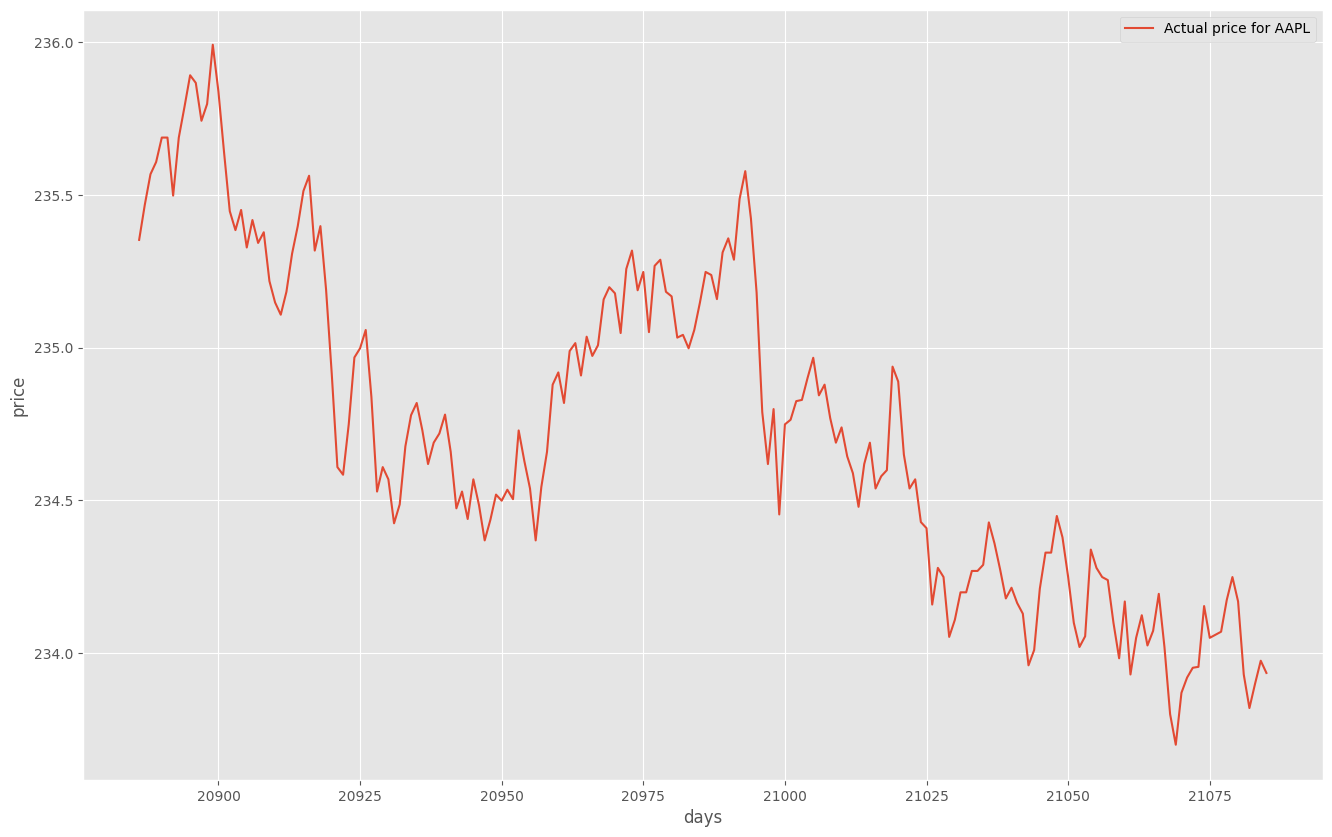

In [8]:
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(data['adj_close'][-200:])
plt.xlabel("days")
plt.ylabel("price")
plt.legend([f'Actual price for {STOCK}'])
plt.show()

In [11]:
# Scale data for ML engine
scaler = MinMaxScaler()
data['close'] = scaler.fit_transform(np.expand_dims(data['adj_close'].values, axis=1))

In [12]:
data.head()

,datetime,adj_close,close
0,2024-07-15 09:06:00,235.128,0.962074
1,2024-07-15 09:07:00,235.148,0.962571
2,2024-07-15 09:08:00,235.148,0.962571
3,2024-07-15 09:09:00,235.078,0.960831
4,2024-07-15 09:10:00,235.108,0.961577


In [ ]:
def PrepareData(days):
    df = data.copy()
    df['future'] = df['close'].shift(-days)
    last_sequence = np.array(df[['close']].tail(days))
    df.dropna(inplace=True)
    sequence_data = []
    sequences = deque(maxlen=N_STEPS)

    for entry, target in zip(df[['close'] + ['datetime']].values, df['future'].values):
        sequences.append(entry)
        if len(sequences) == N_STEPS:
            sequence_data.append([np.array(sequences), target])

    last_sequence = list([s[:len(['close'])] for s in sequences]) + list(last_sequence)
    last_sequence = np.array(last_sequence).astype(np.float32)

    # construct the X's and Y's
    X, Y = [], []
    for seq, target in sequence_data:
        X.append(seq)
        Y.append(target)

    # convert to numpy arrays
    X = np.array(X)
    Y = np.array(Y)

    return df, last_sequence, X, Y

In [ ]:
def GetTrainedModel(x_train, y_train):
  model = Sequential()
  model.add(LSTM(60, return_sequences=True, input_shape=(N_STEPS, len(['close']))))
  model.add(Dropout(0.3))
  model.add(LSTM(120, return_sequences=False))
  model.add(Dropout(0.3))
  model.add(Dense(20))
  model.add(Dense(1))

  BATCH_SIZE = 8
  EPOCHS = 80

  model.compile(loss='mean_squared_error', optimizer='adam')

  checkpoint_path = "stock_prediction.weights.h5"
  checkpoint_dir = os.path.dirname(checkpoint_path)

  # Create a callback that saves the model's weights
  cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                  save_weights_only=True,
                                                  verbose=1)

  model.fit(x_train, y_train,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            callbacks=[cp_callback],
            verbose=1)

  model.summary()

  return model

In [ ]:
# GET PREDICTIONS
predictions = []

for step in LOOKUP_STEPS:
  df, last_sequence, x_train, y_train = PrepareData(step)
  x_train = x_train[:, :, :len(['close'])].astype(np.float32)

  model = GetTrainedModel(x_train, y_train)

  last_sequence = last_sequence[-N_STEPS:]
  last_sequence = np.expand_dims(last_sequence, axis=0)
  prediction = model.predict(last_sequence)
  predicted_price = scaler.inverse_transform(prediction)[0][0]

  predictions.append(round(float(predicted_price), 2))

Epoch 1/80


/Users/jrizzo/Projects/ai/trading/pwbt/.devenv/state/venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2635/2635 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.0062
Epoch 2/80
2635/2635 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 5.6171e-04
Epoch 3/80
2635/2635 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 5.2167e-04
Epoch 4/80
2635/2635 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 5.5372e-04
Epoch 5/80
2635/2635 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 5.1354e-04
Epoch 6/80
2635/2635 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 4.8803e-04
Epoch 7/80
2635/2635 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 4.6883e-04
Epoch 8/80
2635/2635 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 4.2902e-04
Epoch 9/80
2635/2635 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 4.7701e-04
Epoch 10/80
2635/2635 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 4.2508e-04
Epoch 11/80
2635/2635 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 3.9094e-04
Epoch 12/80
2635/2635 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 3.9767e-04
Epoch 13/80
2635/2635 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 3.8529e-04
Epoch 14/80
2635/2635 ━━━━━━━━━━━━━━━━━━━━ 10s 4m

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 7, 60)          │        14,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 7, 60)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 120)            │        86,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 20)             │         2,420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 312,605 (1.19 MB)

 Trainable params: 104,201 (407.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 208,404 (814.08 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
Epoch 1/80


/Users/jrizzo/Projects/ai/trading/pwbt/.devenv/state/venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2635/2635 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.0070
Epoch 2/80
2635/2635 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 6.0634e-04
Epoch 3/80
2635/2635 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 7.0312e-04
Epoch 4/80
2635/2635 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 5.3592e-04
Epoch 5/80
2635/2635 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 5.3419e-04
Epoch 6/80
2635/2635 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 6.0627e-04
Epoch 7/80
2635/2635 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 5.2676e-04
Epoch 8/80
2635/2635 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 5.1097e-04
Epoch 9/80
2635/2635 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 4.7148e-04
Epoch 10/80
2635/2635 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 4.8115e-04
Epoch 11/80
2635/2635 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 4.6079e-04
Epoch 12/80
2635/2635 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 4.5998e-04
Epoch 13/80
2635/2635 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 4.4039e-04
Epoch 14/80
2635/2635 ━━━━━━━━━━━━━━━━━━━━ 10s 4m

In [ ]:
# Execute model for the whole history range
copy_df = data.copy()
y_predicted = model.predict(x_train)
y_predicted_transformed = np.squeeze(scaler.inverse_transform(y_predicted))
first_seq = scaler.inverse_transform(np.expand_dims(y_train[:6], axis=1))
last_seq = scaler.inverse_transform(np.expand_dims(y_train[-3:], axis=1))
y_predicted_transformed = np.append(first_seq, y_predicted_transformed)
y_predicted_transformed = np.append(y_predicted_transformed, last_seq)
copy_df[f'predicted_close'] = y_predicted_transformed

# Add predicted results to the table
date_now = dt.date.today()
date_tomorrow = dt.date.today() + dt.timedelta(days=1)
date_after_tomorrow = dt.date.today() + dt.timedelta(days=2)

copy_df.loc[date_now] = [predictions[0], f'{date_now}', 0, 0]
copy_df.loc[date_tomorrow] = [predictions[1], f'{date_tomorrow}', 0, 0]
copy_df.loc[date_after_tomorrow] = [predictions[2], f'{date_after_tomorrow}', 0, 0]

# Result chart
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(copy_df['close'][-150:].head(147))
plt.plot(copy_df['predicted_close'][-150:].head(147), linewidth=1, linestyle='dashed')
plt.plot(copy_df['close'][-150:].tail(4))
plt.xlabel('days')
plt.ylabel('price')
plt.legend([f'Actual price for {STOCK}', 
            f'Predicted price for {STOCK}',
            f'Predicted price for future 3 days'])
plt.show()